# 1주차 기본 과제
- MNIST 데이터셋 다중 분류

- 구현 환경: 로컬 환경 rtx 4060 gpu만 사용하여 진행.

- python version: 3.9.21

- torch version: 2.2.1 

- 전체 코드 작동 시간: 10분 미만

## [MY CODE] : HyperParameters

- 해당 노트 전체에서 사용되는 하이퍼 파라미터, 혹은 주요 변수를 모아두었습니다. 

In [2]:
import torch
random_state = 42
device = "cuda" if torch.cuda.is_available else "cpu"
batch_size = 256
n_dim = 1024
lr = 1e-3
n_epochs = 100

## [MY CODE] Load Dataset

- 데이터셋을 로드하는 코드 cell 입니다. 

- train, val, test 데이터셋을 구성하여 훈련 중간 val로 점검을 하며 추후 테스트 데이터셋으로 마지막 metric을 찍어볼 예정입니다. 

- train 개수: 60000, val 개수: 8000, val 개수: 2000

- 그리고 transform은 추후에 dataset을 만들 때 사용할 예정입니다.

In [3]:
from sklearn.model_selection import train_test_split 
import torchvision

# train dataset
trainset = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
)
testset = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    # transform=transform
)

test_size= 0.2
x_train = trainset.data.view(-1, 1, 28, 28)
y_train = trainset.targets
x_test = testset.data.view(-1, 1, 28, 28)
y_test = testset.targets
x_val, x_test, y_val, y_test = train_test_split(
    x_test, 
    y_test, 
    test_size=test_size,
    random_state=random_state
)
# Check Dataset Shape
print(f"Train Dataset Shape:\nx_train:{x_train.numpy().shape}, y_train:{y_train.numpy().shape[0]}", end="\n\n")
print(f"Val Dataset Shape:\nx_val:{x_val.numpy().shape}, y_val:{y_val.numpy().shape[0]}", end="\n\n")
print(f"Test Dataset Shape:\nx_test:{x_test.numpy().shape}, y_test:{y_test.numpy().shape[0]}", end="\n\n")

Train Dataset Shape:
x_train:(60000, 1, 28, 28), y_train:60000

Val Dataset Shape:
x_val:(8000, 1, 28, 28), y_val:8000

Test Dataset Shape:
x_test:(2000, 1, 28, 28), y_test:2000



## [MY CODE] Check Label Distribution

- train, val, test의 라벨 분포도 입니다.

- 치우친 데이터 없이 모두 고르게 되어 있습니다. 다중분류 상황에서 문제가 되는 라벨 불균형을 고려하지 않을 예정입니다.

- 라벨의 수는 0~9까지 10입니다. 따라서 다중 모델의 최종 layer의 차원 수는 10입니다. 

In [4]:
import pandas as pd
df = [
    pd.Series(label.numpy())
    .value_counts(normalize=True)
    .sort_index(ascending=True)
        for label in [y_train, y_val, y_test]
]
df = pd.concat(df, axis=1)
df.columns = ['train', 'val', 'test'] 
df

,train,val,test
0,0.098717,0.097125,0.1015
1,0.112367,0.114875,0.1080
2,0.099300,0.102375,0.1065
3,0.102183,0.100250,0.1040
4,0.097367,0.095875,0.1075
5,0.090350,0.089750,0.0870
6,0.098633,0.094750,0.1000
7,0.104417,0.105125,0.0935
8,0.097517,0.098500,0.0930
9,0.099150,0.101375,0.0990


## [MY CODE] Check Label Image

- train, val, test를 모두 검증하기 위하여 코드를 조금 수정하여 num을 입력하면 해당 샘플의 이미지와 라벨을 출력합니다.

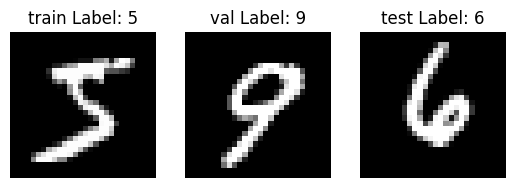

In [5]:
from matplotlib import pyplot as plt

def check_data(num, *args):
    for i, (sort, x, y) in enumerate(args):
        plt.subplot(1,len(args),i+1)
        plt.imshow(x[num][0], cmap='gray')
        plt.title(f"{sort} Label: {y[num]}")
        plt.axis('off')

# 몇 번째 샘플을 보여줄 것인지 결정하는 인자
num=0
check_data(
    num,
    ("train", x_train, y_train), 
    ("val", x_val, y_val), 
    ("test", x_test, y_test)
)

## [MY CODE] Make Torch Dataset

- torch dataset을 구성하여 dataloader에 올리는 것을 기반으로 하였습니다. 
- 또한 transform 과정에서 데이터 전처리에 해당하는 표준화를 수행하였습니다. 


## [FEEDBACK] 
- val, test 데이터셋을 표준화 할 때 평균과 표준편차를 train 데이터 것으로 해야하는지, 아니면 val, test 데이터로 해야 하는지 궁금합니다.

- 전해 듣기로는 data leakage를 막기 위해서, test 데이터의 정보는 일절 활용하지 않고 train의 정보로만 해야한다라고 들어서 일단 이렇게 수행했습니다.

- 그러나 test 데이터의 평균과 표준편차를 사용하는 것이 data leakage에 해당하는지 의문이 들어서 질문을 드렸습니다.

In [6]:
from torch.utils.data import Dataset
import torchvision.transforms as transforms
import numpy as np

class dastaset(Dataset):
    def __init__(self, x, y, transform=None):
        torch.manual_seed(random_state)
        self.x = x
        self.y = y
        self.transform = transform
        
    def __getitem__(self, idx):
        sample_x, sample_y = self.x[idx], self.y[idx]
        if self.transform:
            sample_x = self.transform(sample_x)
        return sample_x, sample_y
    
    def __len__(self):
        return len(self.x)

# data leakage가 의심되어 train 데이터의 평균과 표준편차로 모든 데이터를 표준화했습니다.
transform = transforms.Compose([
    transforms.Lambda(lambda x: x.to(dtype=torch.float)),
    transforms.Normalize((x_train.float().mean() / 255.0,), (x_train.float().std() / 255.0,)),  
])

dataset_dict = {name:dastaset(x,y,transform)
                    for name,x,y in [
                            ('train', x_train, y_train),
                            ('val', x_val, y_val),
                            ('test', x_test, y_test)
                        ]
                }   
print(f"Dataset Keys: {dataset_dict.keys()}", end='\n\n')
for name in dataset_dict.keys():
    print(f"{name} len: {len(dataset_dict[name])}", end='\n\n')

Dataset Keys: dict_keys(['train', 'val', 'test'])

train len: 60000

val len: 8000

test len: 2000



## [MY CODE] Make Torch Dataloader

- train, val, test 데이터 가지고 모두 데이터 로더를 구성하였습니다.

- 코드를 간결하게 작성하기 위해 dict 형태로 묶었습니다.

- val, test는 shuffle을 하면 안된다는 조건이 있었으므로, shuffle_map이라는 dict을 사용해 지정하였습니다.

- 각각의 데이터로더가 잘 작동한는 것을 print를 통해 확인하였습니다.

In [7]:
shuffle_map = {'train':True, 'val': False, 'test': False}

dataloader_dict = {name: torch.utils.data.DataLoader(
                            dataset_dict[name],
                            batch_size = batch_size,
                            shuffle=shuffle_map[name],
                        )
                        for name in dataset_dict.keys()
                    }

for name in dataloader_dict.keys():
    dataiter = iter(dataloader_dict[name])
    images, labels = next(dataiter)
    print(
        f"{name} input shape: {images.shape}",
        f"{name} output shape: {labels.shape}",
        f"{name} batch nums: {len(dataloader_dict[name])}",
        sep='\n',
        end='\n\n'
    )

train input shape: torch.Size([256, 1, 28, 28])
train output shape: torch.Size([256])
train batch nums: 235

val input shape: torch.Size([256, 1, 28, 28])
val output shape: torch.Size([256])
val batch nums: 32

test input shape: torch.Size([256, 1, 28, 28])
test output shape: torch.Size([256])
test batch nums: 8



## [MY CODE] Build Model

- 모델의 구조가 동적으로 변화하는 상황에서도 대응할 수 있도록 model config라는 dict을 따로 선언하였습니다.

- 내부에서는 hidden layers와 final layer를 구분하여 model summary가 더 가시적으로 보이도록 하였습니다. 

- 현재 다중 분류 클래스스 개수가 10개인데, 마지막 출력이 1로 되어있는 것이 이상하다고 생각하여 10으로 정정했습니다. 

- 다중분류 상황에서 loss 함수는 crossentropy를 사용하고 마지막 계층의 활성화 함수는 softmax여야 하지만, crossentropy 함수가 softmax를 계산 과정으로 품고 있기 때문에, 마지막 계층의 활성화함수는 꺼두었습니다.

- 참조: https://stackoverflow.com/questions/55675345/should-i-use-softmax-as-output-when-using-cross-entropy-loss-in-pytorch

In [8]:
from torch import nn

class Model(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.hidden_layers = nn.ModuleDict() 
        for i, (name, (input_dim, output_dim)) in enumerate(config.items()):
            if i + 1 != len(config):
                self.hidden_layers[f"{name}_layer"] = nn.Linear(input_dim, output_dim)
                self.hidden_layers[f"{name}_activation"] = nn.ReLU()

        self.final_layer = nn.ModuleDict() 
        self.final_layer[f"{list(config.keys())[-1]}_layer"] = nn.Linear(list(config.values())[-1][0], list(config.values())[-1][-1])

    def forward(self, x):
        x = x.flatten(start_dim=1)
        for layer in self.hidden_layers.values():
            x = layer(x)
        for layer in self.final_layer.values():
            x = layer(x)
        return x

input_dim = dataset_dict['train'][0][0].shape[1] * dataset_dict['train'][0][0].shape[2]
model_config = {
    "layer1":(input_dim, n_dim),
    "layer2":(n_dim, n_dim),
    "final":(n_dim, 10)
}
model = Model(model_config)
model = model.to(device)
print(model)

Model(
  (hidden_layers): ModuleDict(
    (layer1_layer): Linear(in_features=784, out_features=1024, bias=True)
    (layer1_activation): ReLU()
    (layer2_layer): Linear(in_features=1024, out_features=1024, bias=True)
    (layer2_activation): ReLU()
  )
  (final_layer): ModuleDict(
    (final_layer): Linear(in_features=1024, out_features=10, bias=True)
  )
)


## [MY CODE] Optimizer and Loss function

- optimizer는 그대로 SGD를 사용하였습니다.

- 수정된 사항으로 criterion으로 CrossEntropy 함수를 사용하였습니다.

## [FEEDBACK]

- onehot encoding을 다중 분류 과정에서 해야 한다고 알고 있습니다.

- 그러나 CrossEntropy는 정수 인코딩된 클래스를 요구받는다고 합니다.

- onehot encoding을 안한 것이 metric을 저하시키진 않는지 궁금합니다.

In [9]:
from torch.optim import SGD

optimizer = SGD(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

## [MY CODE] Start Train

- train과 val 데이터로더를 통해 훈련을 하고 있습니다.

- 특징1: loss를 계산할 때 배치당 loss로 평균을 내어서, validation 과정에서 도출 된 loss와 같은 기준선에서 비교가 가능하도록 scaling을 하였습니다.

- 특징2: validation을 매 epoch이 아니라 5 epoch 마다 하여서, 추세를 확인하는 용도로 사용하였습니다.

- 특징3: 다중분류이므로 accuracy와 f1_score를 같이 가져왔습니다. 이 때 sklearn 라이브러리를 활용하여 custom 구현에 의한 오류 발생 여지를 줄였습니다.

## [LOG] Train, Val Metric

- 훈련 과정에서 5 epoch 마다의 metric을 모두 찍고 있습니다.

## [FEEDBACK]

- train과 val 과정에서 한 에폭을 돌았을 때 로스의 평균을 내었는데 1에폭에서 loss가 큰 차이가 났습니다.

- 평균을 냄으로써 1에폭당 평균 로스라는, 같은 스케일로 변환을 했는데 초기에 큰차이가 났습니다.

- 이에 대한 잠정적인 결론으로는, train은 학습이 되는 과정 중에서, val은 최소 1에폭이 학습된 이후에 찍힌 metric이다보니 같은 스케일로 맞췄음에도 값에서 차이가 보인 것이라 생각하였습니다.

- 이것이 맞는지 확인을 받고 싶었습니다.

In [10]:
from sklearn.metrics import accuracy_score, f1_score

train_metric_dict = {'loss':[],'accuracy':[],'f1_score':[]}
val_metric_dict = {'loss':[],'accuracy':[],'f1_score':[]}
for epoch in range(n_epochs):
  total_loss_lst = []
  total_preds_lst=[]
  total_labels_lst=[]

  for inputs, labels in dataloader_dict['train']:
    model.train()
    model.zero_grad()
    inputs, labels = inputs.to(device), labels.to(device).long() 
    preds = model(inputs)
    loss = criterion(preds, labels)

    preds_labels = torch.max(preds, dim=1).indices.detach().cpu().numpy()
    total_preds_lst.extend(preds_labels)
    labels = labels.detach().cpu().numpy()
    total_labels_lst.extend(labels)

    loss.backward()
    optimizer.step()
    total_loss_lst.append(loss.item())
    
  accuracy = accuracy_score(preds_labels, labels)
  f1 = f1_score(preds_labels, labels, average='macro')
  total_loss = np.mean(total_loss_lst)
  
  train_metric_dict['loss'].append(total_loss)
  train_metric_dict['accuracy'].append(accuracy)
  train_metric_dict['f1_score'].append(f1)

  if (epoch+1) % 5 == 1:
    val_loss_lst = []
    val_preds_lst=[]
    val_labels_lst=[]
    for inputs, labels in dataloader_dict['val']:
      model.zero_grad()
      inputs, labels = inputs.to(device), labels.to(device).long() 
      with torch.no_grad():
        model.eval()
        preds = model(inputs)
      loss = criterion(preds, labels)
      preds_labels = torch.max(preds, dim=1).indices.detach().cpu().numpy()
      val_preds_lst.extend(preds_labels)
      labels = labels.detach().cpu().numpy()
      val_labels_lst.extend(labels)
      val_loss_lst.append(loss.item())
    accuracy = accuracy_score(val_preds_lst, val_labels_lst)
    f1 = f1_score(val_preds_lst, val_labels_lst, average='macro')
    val_loss = np.mean(val_loss_lst)

    val_metric_dict['loss'].append((epoch,val_loss))
    val_metric_dict['accuracy'].append((epoch,accuracy))
    val_metric_dict['f1_score'].append((epoch,f1))
    print(f"Train Epoch {epoch+1:3d} | Loss: {total_loss:.3f} | Accuracy: {accuracy:.3f} | F1_Score: {f1:.3f}")
    print(f"Val | Loss: {val_loss:.3f} | Accuracy: {accuracy:.3f} | F1_Score: {f1:.3f}", end='\n\n')

Train Epoch   1 | Loss: 2.873 | Accuracy: 0.931 | F1_Score: 0.930
Val | Loss: 0.302 | Accuracy: 0.931 | F1_Score: 0.930

Train Epoch   6 | Loss: 0.031 | Accuracy: 0.956 | F1_Score: 0.956
Val | Loss: 0.179 | Accuracy: 0.956 | F1_Score: 0.956

Train Epoch  11 | Loss: 0.008 | Accuracy: 0.960 | F1_Score: 0.959
Val | Loss: 0.172 | Accuracy: 0.960 | F1_Score: 0.959

Train Epoch  16 | Loss: 0.004 | Accuracy: 0.962 | F1_Score: 0.962
Val | Loss: 0.168 | Accuracy: 0.962 | F1_Score: 0.962

Train Epoch  21 | Loss: 0.003 | Accuracy: 0.962 | F1_Score: 0.962
Val | Loss: 0.168 | Accuracy: 0.962 | F1_Score: 0.962

Train Epoch  26 | Loss: 0.002 | Accuracy: 0.964 | F1_Score: 0.963
Val | Loss: 0.166 | Accuracy: 0.964 | F1_Score: 0.963

Train Epoch  31 | Loss: 0.002 | Accuracy: 0.964 | F1_Score: 0.964
Val | Loss: 0.165 | Accuracy: 0.964 | F1_Score: 0.964

Train Epoch  36 | Loss: 0.001 | Accuracy: 0.964 | F1_Score: 0.964
Val | Loss: 0.165 | Accuracy: 0.964 | F1_Score: 0.964

Train Epoch  41 | Loss: 0.001 | 

## [MY CODE] Analize Metrics

- train과 val의 loss, accuracy, f1을 plot하였습니다.

## [FEEDBACK]

- val loss가 내려가다가 정지하는 모양이 나타납니다. 

- val loss가 오르지는 않는데 이것이 overfitting의 형태로 볼 수 있을까요?

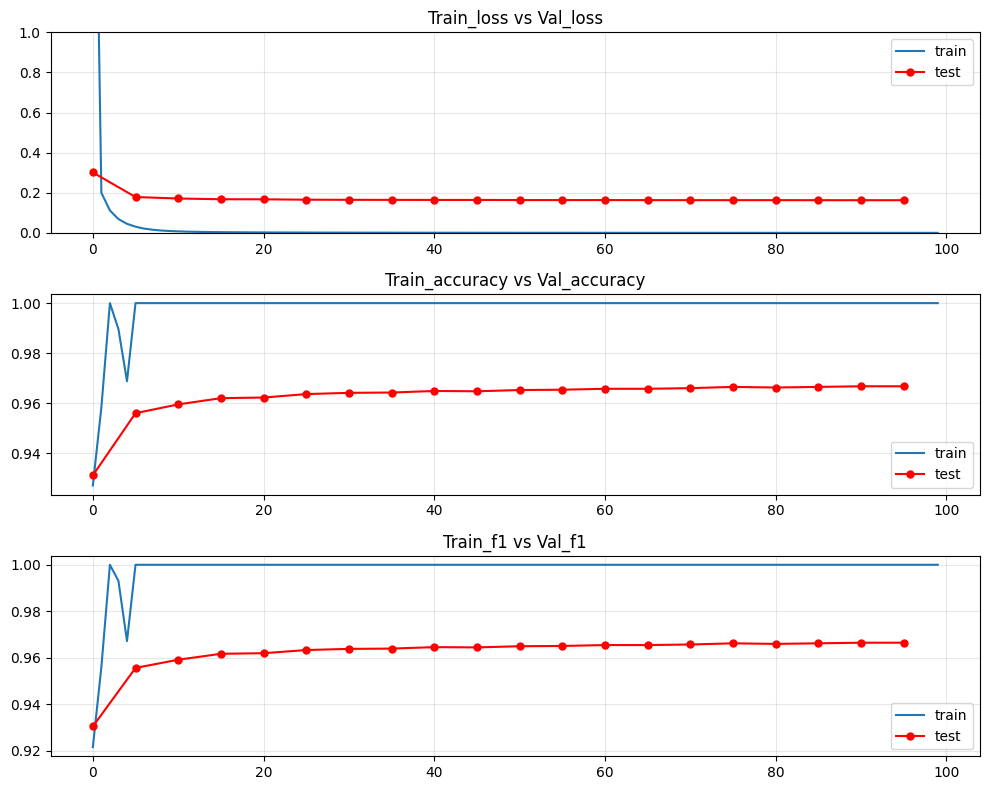

In [13]:
plt.figure(figsize=(10,8))
plt.subplot(3,1,1)
plt.plot(range(len(train_metric_dict['loss'])), train_metric_dict['loss'], label='train')

x = [point[0] for point in val_metric_dict['loss']]
y = [point[1] for point in val_metric_dict['loss']]

plt.plot(x, y, linestyle='-', marker='o', markersize=5, color='red', label='test')
plt.grid(alpha=0.3)
plt.ylim(0.0,1.0)
plt.legend()
plt.title("Train_loss vs Val_loss")

plt.subplot(3,1,2)
plt.plot(range(len(train_metric_dict['accuracy'])), train_metric_dict['accuracy'], label='train')

x = [point[0] for point in val_metric_dict['accuracy']]
y = [point[1] for point in val_metric_dict['accuracy']]

plt.plot(x, y, linestyle='-', marker='o', markersize=5, color='red', label='test')  # s는 점의 크기
plt.grid(alpha=0.3)
plt.legend()
plt.title("Train_accuracy vs Val_accuracy")

plt.subplot(3,1,3)
plt.plot(range(len(train_metric_dict['f1_score'])), train_metric_dict['f1_score'], label='train')

x = [point[0] for point in val_metric_dict['f1_score']]
y = [point[1] for point in val_metric_dict['f1_score']]

plt.plot(x, y, linestyle='-', marker='o', markersize=5, color='red', label='test')
plt.grid(alpha=0.3)
plt.legend()
plt.title("Train_f1 vs Val_f1")
plt.tight_layout()
plt.show()

## [MY CODE] Test Metric

- test 데이터셋을 가지고 최종 metric을 찍어보았습니다.

- val dataset과 비슷한 metric이 나온 것을 보니 훈련이 잘 된 것으로 판단이 되었습니다. 

## [LOG] Test Metric

In [14]:
test_loss_lst = []
test_preds_lst=[]
test_labels_lst=[]
for inputs, labels in dataloader_dict['test']:
    model.zero_grad()
    inputs, labels = inputs.to(device), labels.to(device).long() 
    with torch.no_grad():
        model.eval()
        preds = model(inputs)
    loss = criterion(preds, labels)
    preds_labels = torch.max(preds, dim=1).indices.detach().cpu().numpy()
    test_preds_lst.extend(preds_labels)
    labels = labels.detach().cpu().numpy()
    test_labels_lst.extend(labels)
    test_loss_lst.append(loss.item())
accuracy = accuracy_score(test_preds_lst, test_labels_lst)
f1 = f1_score(test_preds_lst, test_labels_lst, average='macro')
test_loss = np.mean(test_loss_lst)

print(f"Test | Loss: {test_loss:.3f} | Accuracy: {accuracy:.3f} | F1_Score: {f1:.3f}", end='\n\n')

Test | Loss: 0.164 | Accuracy: 0.965 | F1_Score: 0.965

